In [46]:
import json

from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# Preprocess Data

In [2]:
def json2df(json_path):
    """Loads scraped json data into a Pandas DF
    
    """
    # load data from json
    with open(json_path) as f:
        data = json.load(f)

    # preprocess json data and convert to df
    all_postings = []
    for search_term in data:
        all_postings.extend(data[search_term])
    df = pd.DataFrame(all_postings)
    
    # drop duplicate postings by link
    df = df.drop_duplicates(subset='url')
    return df

In [3]:
def process_location(df):
    df["city"] = np.where(df.location.str.contains(","), df.location.str.split(",").str.get(0).str.strip(), None)
    df["province"] = np.where(df.location.str.contains(","), df.location.str.split(",").str.get(1).str.strip(), None)
    df["country"] = np.where(df.location == "Canada", "Canada", None)
    province_list = ["ON", "BC", "QC", "AB", "SK", "MB", "NS", "NB", "PE", "YT", "NL"]
    df.loc[df.province.isin(province_list), "country"] = "Canada"
    df.loc[(df.province == "Canada") | ~(df.province.isin(province_list)), "city"] = None
    df.loc[(df.province == "Canada") | ~(df.province.isin(province_list)), "province"] = None
    df.loc[(df.province == "Canada") | ~(df.province.isin(province_list)), "country"] = "Canada"
    df = df.drop("location", axis=1)
    return df

In [4]:
def process_num_applicants(df):
    df.num_applicants = np.where(df.num_applicants.str.split(" ").str.get(0).str.isdigit(), 
        df.num_applicants.str.split(" ").str.get(0), df.num_applicants)
    df.num_applicants = np.where(df.num_applicants.str.split(" ").str.get(0) == "Over", 100, df.num_applicants)
    df.num_applicants = df.num_applicants.astype("float64")
    return df

In [5]:
def salary_string2annual(salary):
    try:
        amount = salary.split("/")[0].split("$")[-1].replace("$", "")
        if "K" in amount:
            amount = amount.replace("K", "")
            amount = float(amount)*1000
        amount = float(amount)
        term = salary.split("/")[1].split(" ")[0]
        if term == 'hr':
            amount = amount*2000
    except Exception as e:
        #print(e)
        amount = salary
    return amount

In [6]:
def process_salary(df):
    df.salary = np.where(df.salary.str.contains("$", regex=False), df.salary, None)
    salaries = []
    for i in range(len(df)):
        salary = df.iloc[i].salary
        if salary is not None:
            try:
                if salary.count("$") == 1:
                    # the salary is not a range
                    salaries.append(salary_string2annual(salary))
                else:
                    split_salary_string = salary.split(" ")
                    lower, upper = "", ""
                    for word in split_salary_string:
                        if "$" in word:
                            if lower == "":
                                lower = word
                            else:
                                upper = word
                                break
                    mean_amount = (salary_string2annual(lower) + salary_string2annual(upper))/2
                    salaries.append(mean_amount)
            except Exception as e:
                print(e)
                pass
        else:
            salaries.append(None)
    df["annual_salary"] = salaries
    df = df.drop("salary", axis=1)
    return df

In [7]:
def add_glassdoor_salaries(df, json_path):
    with open(json_path) as f:
        glassdoor_salaries = json.load(f)
    annual_salaries = df.annual_salary.to_list()
    for i in range(len(df)):
        if pd.isnull(annual_salaries[i]):
            url = df.iloc[i].url
            if url in glassdoor_salaries:
                annual_salaries[i] = glassdoor_salaries[url]
    df.annual_salary = annual_salaries
    df.annual_salary = df.annual_salary.astype('float64')
    return df

In [8]:
def preprocess_scraped_data(linkedin_json_path, glassdoor_json_path):
    df = json2df(linkedin_json_path)
    df = process_location(df)
    df = process_num_applicants(df)
    df = process_salary(df)
    df = add_glassdoor_salaries(df, glassdoor_json_path)
    df["job_title"] = df.title
    df = df.drop("title", axis=1)
    df = df[["job_title", "employer", "num_applicants", "annual_salary", "city", "province", "country", "description", "url"]]
    df.to_pickle("linkedin_scraped_posts_0407_processed.pkl")

In [9]:
preprocess_scraped_data("data/linkedin_scraped_posts_0407.json", "data/glassdoor_scraped_salaries_0407.json")

In [10]:
df = pd.read_pickle("linkedin_scraped_posts_0407_processed.pkl")

In [11]:
# drop title + employer duplicates
df = df.drop_duplicates(subset=["job_title", "employer"])

In [12]:
# check jobs missing salaries
df[~(df.annual_salary > 0)]

,job_title,employer,num_applicants,annual_salary,city,province,country,description,url
387,Volunteer: Financial Analyst (Remote/Unpaid Vo...,VolunteerMatch,86.0,0.0,Calgary,AB,Canada,About the job\nEmpowered Futures is a non-prof...,https://www.linkedin.com/jobs/view/3817534547/...
949,Software Engineer (Python) - Up to CAD$180k + ...,Hunter Bond,37.0,NaN,None,None,Canada,About the job\nClient: \nA prestigious technol...,https://www.linkedin.com/jobs/view/3882857588/...
975,Growth Hacker,Let's Roam,36.0,NaN,None,None,Canada,About the job\nGrowth Marketing & Product Inno...,https://www.linkedin.com/jobs/view/3862563221/...
1021,MLOps Software Engineer - Elite AI Team - Up t...,Hunter Bond,27.0,NaN,Montreal,QC,Canada,About the job\nJob Title: MLOps Software Engin...,https://www.linkedin.com/jobs/view/3879743623/...


In [13]:
display(df.loc[949].job_title)
display(df.loc[975].job_title)
display(df.loc[1021].job_title)

'Software Engineer (Python) - Up to CAD$180k + Huge Bonus Montreal'

'Growth Hacker'

'MLOps Software Engineer - Elite AI Team - Up to $140k CAD + Bonus'

In [14]:
# update salaries based on title and glassdoor search
df.loc[949, "annual_salary"] = 180000
df.loc[975, "annual_salary"] = 55000
df.loc[1021, "annual_salary"] = 140000

In [15]:
# remove volunteer position to avoid outliers
df = df.drop(387)

In [16]:
df[~(df.annual_salary > 0)]

,job_title,employer,num_applicants,annual_salary,city,province,country,description,url


In [17]:
df = df.reset_index()
df = df.drop('index', axis=1)
print(len(df))

596


# Analysis and Feature Engineering

In [82]:
df.head()

,job_title,employer,num_applicants,annual_salary,city,province,country,description,url,is_junior,is_intermediate,is_senior,is_manager,is_lead,is_director,is_vp,is_ai,is_engineer,is_scientist,is_analyst,is_finance,is_data,is_developer,is_architect,is_python,is_quantitative,is_remote,is_bilingual,is_internship,is_security,years_experience,number_of_experiences
0,Senior Data Scientist,Akkodis,0.76,118000.0,Toronto,ON,Canada,About the job\nHi Candidate\nI hope you are do...,https://www.linkedin.com/jobs/view/3881928212/...,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7.0,3
1,Lead Data Scientist/Machine Learning Engineer ...,Agoda,0.41,132000.0,Toronto,ON,Canada,About the job\nAbout Agoda\n\nAgoda is an onli...,https://www.linkedin.com/jobs/view/3839799162/...,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,4.0,1
2,"Practice Lead Data Scientist, Data Driven Mark...",Cogeco Connexion,0.41,120000.0,Montreal,QC,Canada,About the job\nOur culture lifts you up—there ...,https://www.linkedin.com/jobs/view/3848292659/...,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10.0,1
3,Senior Data Scientist,Clio - Cloud-Based Legal Technology,1.00,165000.0,None,None,Canada,About the job\nClio is more than just a tech c...,https://www.linkedin.com/jobs/view/3827050664/...,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,5.0,1
4,Lead Data Scientist,Logikk,1.00,132000.0,Montreal,QC,Canada,About the job\nLead Data Scientist - Leading A...,https://www.linkedin.com/jobs/view/3865773248/...,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,NaN,0


In [83]:
def cross_with_annual_salary(df, other_column, num_cuts):
    percentiles = []
    for i in range(num_cuts):
        next_percentile = round(np.nanpercentile(df[other_column], i*100/(num_cuts)), 2)
        if next_percentile not in percentiles:
            percentiles.append(next_percentile)
    percentiles.append(max(df[other_column]))

    formatted_ranges, mean_salaries = [], []
    for i in range(1, len(percentiles)):
        if i != len(percentiles)-1:
            formatted_ranges.append(f"[{percentiles[i-1]}-{percentiles[i]})")
            mean_salaries.append(round(df[(df[other_column] >= percentiles[i-1]) & (df[other_column] < percentiles[i])].annual_salary.mean(), 2))
        else:
            formatted_ranges.append(f"[{percentiles[i-1]}-{percentiles[i]}]")
            mean_salaries.append(round(df[(df[other_column] >= percentiles[i-1]) & (df[other_column] <= percentiles[i])].annual_salary.mean(), 2))
    
    display_df = pd.DataFrame()
    display_df[other_column] = formatted_ranges
    display_df["Mean Annual Salary"] = mean_salaries
    return display_df

In [84]:
# salary by number of applicants
cross_with_annual_salary(df, "num_applicants", 10)

,num_applicants,Mean Annual Salary
0,[0.0-0.14),86271.19
1,[0.14-0.29),87416.43
2,[0.29-0.53),87218.55
3,[0.53-0.81),83020.83
4,[0.81-1.0),94984.38
5,[1.0-1.0],90964.22


In [85]:
# salary by city
df.groupby("city").annual_salary.agg(['count', 'min', 'max', 'mean']).sort_values(by='count', ascending=False)[:10]

,count,min,max,mean
city,,,,
Toronto,129,50000.0,200000.0,91430.232558
Vancouver,76,35500.0,180000.0,86513.157895
Montreal,64,40000.0,154000.0,89071.093750
Calgary,34,37500.0,137500.0,82220.588235
Winnipeg,18,55000.0,128000.0,84805.555556
Mississauga,15,26000.0,200000.0,84766.666667
Markham,11,59000.0,123000.0,90909.090909
Ottawa,10,59000.0,200000.0,98000.000000
Regina,10,50000.0,91000.0,70300.000000


In [86]:
# salary by province
df.groupby("province").annual_salary.agg(['count', 'min', 'max', 'mean']).sort_values(by='mean', ascending=False)[:10]

,count,min,max,mean
province,,,,
ON,205,26000.0,200000.0,89404.878049
QC,86,31000.0,154000.0,85587.790698
MB,18,55000.0,128000.0,84805.555556
BC,104,35500.0,180000.0,84537.211538
NB,3,59000.0,132000.0,83333.333333
AB,45,37500.0,137500.0,81422.222222
NS,3,57000.0,107000.0,79666.666667
SK,11,50000.0,91000.0,71409.090909
YT,1,36500.0,36500.0,36500.000000


In [87]:
# check how different title pronouns impact salary
def compare_titles(titles):
    title_names, min, mean, max = [], [], [], []
    for title in titles:
        title_names.append(title)
        subset = df[df.job_title.str.lower().str.contains('|'.join(titles[title]))]
        min.append("$" + str(subset.annual_salary.min()))
        mean.append("$" + str(round(subset.annual_salary.mean(), 2)))
        max.append("$" + str(subset.annual_salary.max()))
    display_df = pd.DataFrame()
    display_df["Job Title"] = title_names
    display_df["Min Annual Salary"] = min
    display_df["Mean Annual Salary"] = mean
    display_df["Max Annual Salary"] = max
    return display_df
    
titles = {
    "Junior": ["jr", "junior"],
    "Intermediate": ["intermediate"],
    "Average": [""],
    "Senior": ["sr", "senior"],
    "Manager": ["manage"],
    "Lead": ["lead"],
    "Director": ["director"],
    "Vice President": ["vp"]
}
compare_titles(titles)

,Job Title,Min Annual Salary,Mean Annual Salary,Max Annual Salary
0,Junior,$45500.0,$66500.0,$115000.0
1,Intermediate,$65000.0,$71166.67,$76000.0
2,Average,$26000.0,$89192.82,$210000.0
3,Senior,$46000.0,$96076.36,$205000.0
4,Manager,$54500.0,$102409.09,$200000.0
5,Lead,$37500.0,$120108.7,$200000.0
6,Director,$137500.0,$137500.0,$137500.0
7,Vice President,$154000.0,$164750.0,$175500.0


In [88]:
# check for keywords in title impact summary
titles = {
    "Average": [""],
    "AI": ["ai", "ml", "machine learning"],
    "Engineer": ["engineer"],
    "Scientist": ["scientist"],
    "Analyst": ["analyst"],
    "Finance": ["financial", "finance"],
    "Data": ["data"],
    "Developer": ["developer"],
    "Architect": ["architect"],
    "Python": ["python"],
    "Quantitative": ["quant"],
    "Remote": ["remote"],
    "Bilingual": ["bilingual"],
    "Internship": ["intern", "coop", "co-op"],
    "Security": ["security"],
    "Full Stack": ["full stack"],
    "Business": ["business"],
    "Product": ["product"]
}
compare_titles(titles)

,Job Title,Min Annual Salary,Mean Annual Salary,Max Annual Salary
0,Average,$26000.0,$89192.82,$210000.0
1,AI,$45000.0,$106011.05,$205000.0
2,Engineer,$37500.0,$106133.66,$205000.0
3,Scientist,$50000.0,$104835.16,$187500.0
4,Analyst,$26000.0,$76643.63,$162000.0
5,Finance,$35500.0,$75705.49,$175500.0
6,Data,$26000.0,$92879.95,$187500.0
7,Developer,$50000.0,$90450.98,$200000.0
8,Architect,$90000.0,$111583.33,$143500.0
9,Python,$60000.0,$91252.27,$180000.0


In [89]:
# add title pronouns as features
df["is_junior"] = np.where((df.job_title.str.lower().str.contains("jr")) | (df.job_title.str.lower().str.contains("junior")), 1, 0)
df["is_intermediate"] = np.where(df.job_title.str.lower().str.contains("intermediate"), 1, 0)
df["is_senior"] = np.where((df.job_title.str.lower().str.contains("sr")) | (df.job_title.str.lower().str.contains("senior")), 1, 0)
df["is_manager"] = np.where(df.job_title.str.lower().str.contains("manage"), 1, 0)
df["is_lead"] = np.where(df.job_title.str.lower().str.contains("lead"), 1, 0)
df["is_director"] = np.where(df.job_title.str.lower().str.contains("director"), 1, 0)
df["is_vp"] = np.where(df.job_title.str.lower().str.contains("vp"), 1, 0)

# add title keywords as features
df["is_ai"] = np.where((df.job_title.str.lower().str.contains("ai")) | (df.job_title.str.lower().str.contains("ml")) | (df.job_title.str.lower().str.contains("machine learning")), 1, 0)
df["is_engineer"] = np.where(df.job_title.str.lower().str.contains("engineer"), 1, 0)
df["is_scientist"] = np.where(df.job_title.str.lower().str.contains("scientist"), 1, 0)
df["is_analyst"] = np.where(df.job_title.str.lower().str.contains("analyst"), 1, 0)
df["is_finance"] = np.where((df.job_title.str.lower().str.contains("finance")) | (df.job_title.str.lower().str.contains("financial")), 1, 0)
df["is_data"] = np.where(df.job_title.str.lower().str.contains("data"), 1, 0)
df["is_developer"] = np.where(df.job_title.str.lower().str.contains("developer"), 1, 0)
df["is_architect"] = np.where(df.job_title.str.lower().str.contains("architect"), 1, 0)
df["is_python"] = np.where(df.job_title.str.lower().str.contains("python"), 1, 0)
df["is_quantitative"] = np.where(df.job_title.str.lower().str.contains("quant"), 1, 0)
df["is_remote"] = np.where(df.job_title.str.lower().str.contains("remote"), 1, 0)
df["is_bilingual"] = np.where(df.job_title.str.lower().str.contains("bilingual"), 1, 0)
df["is_internship"] = np.where((df.job_title.str.lower().str.contains("intern")) | (df.job_title.str.lower().str.contains("coop")) | (df.job_title.str.lower().str.contains("co-op")), 1, 0)
df["is_security"] = np.where(df.job_title.str.lower().str.contains("security"), 1, 0)
df["is_fullstack"] = np.where(df.job_title.str.lower().str.contains("fullstack"), 1, 0)
df["is_business"] = np.where(df.job_title.str.lower().str.contains("business"), 1, 0)
df["is_product"] = np.where(df.job_title.str.lower().str.contains("product"), 1, 0)

In [90]:
# find maximum number of years experience in description
# and also number of different experiences required
def parse_int(word):
    word = word.split('-')[-1]
    final_int = ""
    for char in word:
        if char.isnumeric():
            final_int += char
        elif len(final_int):
            break
    if not len(final_int):
        final_int = -1
    return int(final_int)

years_experience, number_of_experiences = [], []
for desc in df.description.tolist():
    highest_years = None
    num_experiences = 0
    split = desc.lower().split('year')
    if len(split) > 1:
        for i, phrase in enumerate(split):
            if 'experience' in phrase[-100:] or (i < len(split) - 1 and 'experience' in split[i+1][:100]):
                split_phrase = phrase.strip().split(' ')
                num_years = parse_int(split_phrase[-1])
                if num_years > 0:
                    num_experiences += 1
                    if highest_years is None or num_years > highest_years:
                        highest_years = num_years
    years_experience.append(highest_years)
    number_of_experiences.append(num_experiences)
df['years_experience'] = years_experience
df['number_of_experiences'] = number_of_experiences
df.loc[df.years_experience > 15, 'years_experience'] = None

In [91]:
cross_with_annual_salary(df, "years_experience", 5)

,years_experience,Mean Annual Salary
0,[1.0-3.0),90220.00
1,[3.0-4.0),88035.26
2,[4.0-5.0),93885.71
3,[5.0-6.0),92848.66
4,[6.0-14.0],97857.59


In [92]:
cross_with_annual_salary(df, "number_of_experiences", 10)

,number_of_experiences,Mean Annual Salary
0,[0.0-1.0),84227.92
1,[1.0-2.0),90112.68
2,[2.0-5],98031.58


In [93]:
df.head()

,job_title,employer,num_applicants,annual_salary,city,province,country,description,url,is_junior,is_intermediate,is_senior,is_manager,is_lead,is_director,is_vp,is_ai,is_engineer,is_scientist,is_analyst,is_finance,is_data,is_developer,is_architect,is_python,is_quantitative,is_remote,is_bilingual,is_internship,is_security,years_experience,number_of_experiences,is_fullstack,is_business,is_product
0,Senior Data Scientist,Akkodis,0.76,118000.0,Toronto,ON,Canada,About the job\nHi Candidate\nI hope you are do...,https://www.linkedin.com/jobs/view/3881928212/...,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7.0,3,0,0,0
1,Lead Data Scientist/Machine Learning Engineer ...,Agoda,0.41,132000.0,Toronto,ON,Canada,About the job\nAbout Agoda\n\nAgoda is an onli...,https://www.linkedin.com/jobs/view/3839799162/...,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,4.0,1,0,0,0
2,"Practice Lead Data Scientist, Data Driven Mark...",Cogeco Connexion,0.41,120000.0,Montreal,QC,Canada,About the job\nOur culture lifts you up—there ...,https://www.linkedin.com/jobs/view/3848292659/...,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10.0,1,0,0,0
3,Senior Data Scientist,Clio - Cloud-Based Legal Technology,1.00,165000.0,None,None,Canada,About the job\nClio is more than just a tech c...,https://www.linkedin.com/jobs/view/3827050664/...,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,5.0,1,0,0,0
4,Lead Data Scientist,Logikk,1.00,132000.0,Montreal,QC,Canada,About the job\nLead Data Scientist - Leading A...,https://www.linkedin.com/jobs/view/3865773248/...,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,NaN,0,0,0,0


# Model Training

In [94]:
df.dtypes

job_title                 object
employer                  object
num_applicants           float64
annual_salary            float64
city                      object
province                  object
country                   object
description               object
url                       object
is_junior                  int32
is_intermediate            int32
is_senior                  int32
is_manager                 int32
is_lead                    int32
is_director                int32
is_vp                      int32
is_ai                      int32
is_engineer                int32
is_scientist               int32
is_analyst                 int32
is_finance                 int32
is_data                    int32
is_developer               int32
is_architect               int32
is_python                  int32
is_quantitative            int32
is_remote                  int32
is_bilingual               int32
is_internship              int32
is_security                int32
years_expe

In [95]:
# restrict dataset only to important cities
important_cities = df.city.value_counts()[:10].index.tolist()
df.loc[~df.city.isin(important_cities), "city"] = None

In [96]:
# normalize num_applicants
df.num_applicants = df.num_applicants/100

In [132]:
# clean dataset and split into train and test
good_cols = []
for col in df:
    if df[col].dtype != "object":
        good_cols.append(col)
# manually add province and city, and then convert to dummys
good_cols.extend(["city", "province"])
X = df[good_cols]
X = pd.get_dummies(X)

# separate labels and create test and train data
y = X.annual_salary
y_max = y.max()
y = y / y_max
X = X.drop("annual_salary", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=57)

In [133]:
X_train.columns

Index(['num_applicants', 'is_junior', 'is_intermediate', 'is_senior',
       'is_manager', 'is_lead', 'is_director', 'is_vp', 'is_ai', 'is_engineer',
       'is_scientist', 'is_analyst', 'is_finance', 'is_data', 'is_developer',
       'is_architect', 'is_python', 'is_quantitative', 'is_remote',
       'is_bilingual', 'is_internship', 'is_security', 'years_experience',
       'number_of_experiences', 'is_fullstack', 'is_business', 'is_product',
       'city_Calgary', 'city_Edmonton', 'city_Markham', 'city_Mississauga',
       'city_Montreal', 'city_Ottawa', 'city_Regina', 'city_Toronto',
       'city_Vancouver', 'city_Winnipeg', 'province_AB', 'province_BC',
       'province_MB', 'province_NB', 'province_NS', 'province_ON',
       'province_QC', 'province_SK', 'province_YT'],
      dtype='object')

In [139]:
# find optimal hyperparameters

def test_hyperparameters(**hyper_parameters):
    hyper_parameters["n_estimators"] = int(hyper_parameters["n_estimators"])
    hyper_parameters["max_depth"] = int(hyper_parameters["max_depth"])
    xgbc = XGBRegressor(**hyper_parameters, objective="reg:squarederror")
    xgbc.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
    return -xgbc.evals_result()["validation_0"]["rmse"][-1]
    

pbounds = {
    "max_depth": (2, 6),
    "min_child_weight": (1, 100),
    "lambda": (1, 50),
    "alpha": (1, 50),
    "n_estimators": (1, 200),
    "learning_rate": (0.05, 1)
}

optimizer = BayesianOptimization(
    test_hyperparameters,
    pbounds=pbounds,
    verbose=2,
    random_state=57,
)

optimizer.maximize(
    init_points=2,
    n_iter=30,
)

|   iter    |  target   |   alpha   |  lambda   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.1231   | 5.28      | 12.29     | 0.4405    | 3.243     | 57.03     | 109.5     |
| 2         | -0.1443   | 40.55     | 45.99     | 0.546     | 3.699     | 8.109     | 179.8     |
| 3         | -0.1103   | 2.317     | 16.35     | 0.5354    | 4.731     | 53.36     | 110.3     |
| 4         | -0.1077   | 1.795     | 22.38     | 0.4974    | 5.124     | 49.63     | 110.3     |
| 5         | -0.1101   | 1.0       | 14.47     | 1.0       | 6.0       | 39.24     | 119.2     |
| 6         | -0.1081   | 1.0       | 15.18     | 1.0       | 6.0       | 36.57     | 99.9      |
| 7         | -0.1443   | 42.24     | 14.0      | 0.7834    | 4.909     | 7.262     | 1.104     |
| 8         | -0.111    | 3.103     | 27.36     | 0.7002    | 3.54      | 48.93     | 109.4     |
| 9         | -0.095

In [140]:
# check optimal hyperparameters
optimizer.max["params"]

{'alpha': 1.0,
 'lambda': 2.0828671357491757,
 'learning_rate': 1.0,
 'max_depth': 6.0,
 'min_child_weight': 10.842497230521364,
 'n_estimators': 99.36346475129756}

In [141]:
# train final model
best_hyperparameters = optimizer.max["params"]
best_hyperparameters["n_estimators"] = int(best_hyperparameters["n_estimators"])
best_hyperparameters["max_depth"] = int(best_hyperparameters["max_depth"])
xgbc_final = XGBRegressor(**best_hyperparameters, objective="reg:squarederror")
xgbc_final.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

XGBRegressor(alpha=1.0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=2.0828671357491757,
             learning_rate=1.0, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=10.842497230521364, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=99,
             n_jobs=None, ...)

# Model Evaluation

In [168]:
# generate test data predictions
predictions = xgbc_final.predict(X_test)
display_df = pd.DataFrame()
display_df["predictions"] = predictions
display_df["actual"] = y_test.tolist()

diff = abs(display_df.predictions - display_df.actual)*y_max
diff.agg(["min", "median", "mean", "max"])

min         532.444239
median     9632.090688
mean      13641.343012
max       65611.372292
dtype: float64

In [171]:
# check confidence interval
cutoff = 17500
print(f"Out of {len(diff)} test cases, {len(diff[diff <= cutoff])} predictions ({round(len(diff[diff <= cutoff])/len(diff)*100, 2)}%) were within ${cutoff}")

Out of 60 test cases, 51 predictions (85.0%) were within $17500


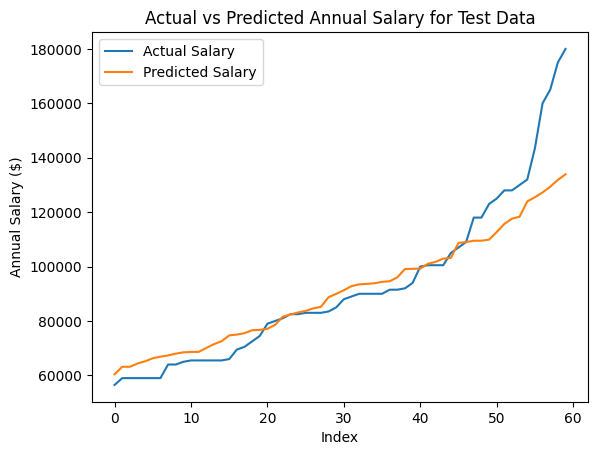

In [184]:
# compare distributions (looks like model struggles to predict outliers on higher end of salaries)
display_df = pd.DataFrame()
actual, display_preds = y_test[:], predictions[:]
actual, display_preds = np.sort(actual), np.sort(display_preds)
display_df["Actual Salary"] = actual*y_max
display_df["Predicted Salary"] = display_preds*y_max
plt = display_df.plot(title="Actual vs Predicted Annual Salary for Test Data", xlabel="Index", ylabel="Annual Salary ($)")

In [197]:
# bucket differences
display_df = pd.DataFrame()
display_df["error"] = abs(predictions - y_test)*y_max
display_df["counter"] = 1
pd.crosstab(pd.cut(display_df.error, 5, precision=0), 
            display_df.counter, rownames=["Abs Error ($)"], colnames=["% of Observations Within Error Range"], normalize=True)

% of Observations Within Error Range,1
Abs Error ($),
"(467.0, 13548.0]",0.700000
"(13548.0, 26564.0]",0.183333
"(26564.0, 39580.0]",0.033333
"(39580.0, 52596.0]",0.033333
"(52596.0, 65611.0]",0.050000
